# Use Gensim to vectorize features2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import numexpr as ne
import mskcc_functions as ski
import scipy.stats as scs
import feature_engineering as fe
import xgboost as xgb

from xgboost import plot_importance
from pprint import pprint
from matplotlib  import cm
from collections import Counter
from importlib import reload
from gensim import corpora, matutils, models, similarities
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

sns.set_context("paper")
%matplotlib inline

Using TensorFlow backend.
/usr/lib64/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
Slow version of gensim.models.doc2vec is being used


In [2]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])

<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<ipython-input-2-4467bb76c423>:2: DeprecationWarning: invalid escape sequence \|
  text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',


In [3]:
feature_words1= pd.read_csv('./data/features_pass1.csv', header=None)
feature_words1 = list(feature_words1[0])
feature_words2 = list(set(class_train['Gene']))
feature_words = feature_words1 + feature_words2
print(len(feature_words))

24223


In [4]:
my_dict = corpora.Dictionary([feature_words])

In [5]:
%%time
documents = []
tokenized_documents = []
for i in range(len(text_train)):
    doc= text_train['Text'].iloc[i]
    tokenized_doc = word_tokenize(fe.replace_with_whitespace(doc, hyphens='on'))
    
    documents.append(doc)
    tokenized_documents.append(tokenized_doc)

print(len(documents))     # double checking length
print(len(tokenized_documents))     # double checking length

3321
3321
CPU times: user 1min 52s, sys: 531 ms, total: 1min 52s
Wall time: 1min 52s


In [8]:
%%time
pd.DataFrame(tokenized_documents).to_csv('./data/tokenized_documents.csv', index=False)

In [9]:
%time
corpus = [my_dict.doc2bow(token) for token in tokenized_documents]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


In [10]:
feature_matrix = matutils.corpus2dense(corpus_tfidf, num_terms=len(feature_words), num_docs=len(corpus_tfidf)).T

In [11]:
feat_mat = pd.DataFrame(feature_matrix)
feat_mat.to_csv('./data/feature_matrix_pass1_TfIdf.csv', index=False)

In [12]:
# Import Data and extract gene and mutation type info
# Get Gene feature from 'train_variants' data
X_gene = np.array(class_train.Gene)
X_gene_int = LabelEncoder().fit_transform(X_gene.ravel()).reshape(-1, 1)
X_gene_bin = OneHotEncoder().fit_transform(X_gene_int).toarray()
gene_table = pd.DataFrame(X_gene_bin)

# Get Mutation Type from 'train_variants' data
mut_type = ski.convert_mutation_type(class_train)
X_mtype = np.array(mut_type['mutation_type'])
X_mtype_int = LabelEncoder().fit_transform(X_mtype.ravel()).reshape(-1, 1)
X_mtype_bin = OneHotEncoder().fit_transform(X_mtype_int).toarray()
mtype_table = pd.DataFrame(X_mtype_bin)

features = pd.concat([gene_table, mtype_table, feat_mat], axis=1)
print(features.shape)

(3321, 24504)


In [13]:
X = np.array(features).astype(float)
y = np.array(class_train.Class).astype(int).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

<b>RFC</b>

In [14]:
%%time
# Run RFC on the data
rfc = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=4)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)
print(accuracy_score(y_test, y_pred))
print(log_loss(y_test, y_proba, labels=list(range(1, 10))))

0.625250501002
1.3423220811
CPU times: user 19.6 s, sys: 86.5 ms, total: 19.6 s
Wall time: 5.41 s


<b>XGBoost</b>

========== Iteration 1/1 ==========
[0]	train-mlogloss:2.08427	valid-mlogloss:2.10897
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[102]	train-mlogloss:0.281969	valid-mlogloss:0.926505

Average mlogloss: 0.926505
CPU times: user 1h 56min 42s, sys: 1.24 s, total: 1h 56min 43s
Wall time: 29min 18s


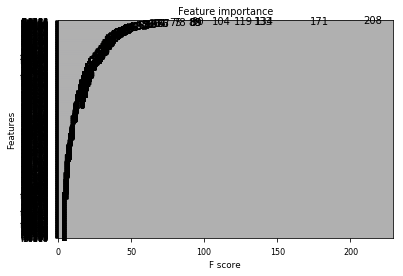

In [15]:
%%time
# Adjust the class labels so it starts with 0
y_adj = y-1

scores = []

iteration = 1
for i in range(iteration):
    print('========== Iteration %d/%d ==========' % (i+1, iteration))
    
    # Split into test and train randomly, every iteration
    x1, x2, y1, y2 = train_test_split(X, y_adj, test_size=0.15)
    
    # Set up parameters for xgboost
    params = {
            'eta': 0.1,
            'gamma': 0.8,
            'max_delta_step': 1,
            'max_depth': 12,
            'min_child_weight': 1,
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'num_class': 9,
            'seed': 1,
            'silent': True,
            'nthread' :4
            }

    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

    model = xgb.train(params, xgb.DMatrix(x1, y1), 300,  watchlist, 
                      verbose_eval=30, early_stopping_rounds=30)

    score = log_loss(y2, model.predict(xgb.DMatrix(x2), 
                     ntree_limit=model.best_ntree_limit), 
                     labels = list(range(9)))
    scores.append(score)
    #print(score)
          
print("Average mlogloss: %f" % np.mean(scores))
plot_importance(model)

In [16]:
len(model.get_score())

1186

<b>Take top 20% features based on F-score, retry classification</b>

In [17]:
fscores = pd.DataFrame([val for val in model.get_score().values()])
fscores.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9])

,0
count,1186.000000
mean,11.887015
std,16.358764
min,1.000000
25%,2.000000
50%,6.000000
75%,16.000000
80%,19.000000
90%,30.000000
max,208.000000


In [18]:
select_feat_ind = [int(key.replace('f', '')) for key, value in model.get_score().items() if value >=19]

selectX1 = X[:, select_feat_ind]
print('Before selection', X.shape)
print('After selection', selectX1.shape)

Before selection (3321, 24504)
After selection (3321, 241)


In [21]:
features.iloc[:, select_feat_ind].to_csv('./data/feature_matrix_pass2_TfIdf.csv', index=False)

========== Iteration 1/1 ==========
[0]	train-mlogloss:2.08436	valid-mlogloss:2.10794
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[100]	train-mlogloss:0.288874	valid-mlogloss:0.944297
[200]	train-mlogloss:0.288458	valid-mlogloss:0.943956
Stopping. Best iteration:
[137]	train-mlogloss:0.288487	valid-mlogloss:0.943917

Average mlogloss: 0.943917
CPU times: user 2min 18s, sys: 90 ms, total: 2min 18s
Wall time: 34.9 s


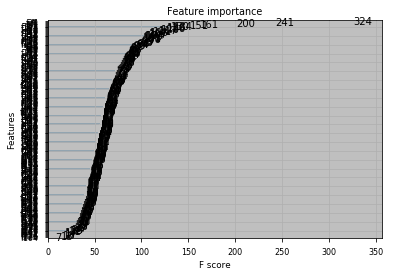

In [22]:
%%time
# Adjust the class labels so it starts with 0
y_adj = y-1

scores = []

iteration = 1
for i in range(iteration):
    print('========== Iteration %d/%d ==========' % (i+1, iteration))
    
    # Split into test and train randomly, every iteration
    x1, x2, y1, y2 = train_test_split(selectX1, y_adj, test_size=0.15)
    
    # Set up parameters for xgboost
    params = {
            'eta': 0.1,
            'gamma': 0.8,
            'max_delta_step': 1,
            'max_depth': 12,
            'min_child_weight': 1,
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'num_class': 9,
            'seed': 1,
            'silent': True,
            'nthread' :4
            }

    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

    model2 = xgb.train(params, xgb.DMatrix(x1, y1), 500,  watchlist, 
                      verbose_eval=100, early_stopping_rounds=100)

    score = log_loss(y2, model2.predict(xgb.DMatrix(x2), 
                     ntree_limit=model2.best_ntree_limit), 
                     labels = list(range(9)))
    scores.append(score)
          
print("Average mlogloss: %f" % np.mean(scores))
plot_importance(model2)

<b>Take features with non-zero F-score, retry classification</b>

In [23]:
select_feat_ind2 = [int(key.replace('f', '')) for key, value in model.get_score().items() if value >=1]

selectX2 = X[:, select_feat_ind2]
print('Before selection', X.shape)
print('After selection', selectX2.shape)

Before selection (3321, 24504)
After selection (3321, 1186)


In [24]:
features.iloc[:, select_feat_ind2].to_csv('./data/feature_matrix_pass3_TfIdf.csv', index=False)

========== Iteration 1/1 ==========
[0]	train-mlogloss:2.08482	valid-mlogloss:2.11047
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[100]	train-mlogloss:0.287601	valid-mlogloss:0.885415
[200]	train-mlogloss:0.285352	valid-mlogloss:0.885094
Stopping. Best iteration:
[106]	train-mlogloss:0.286666	valid-mlogloss:0.884814

Average mlogloss: 0.884814
CPU times: user 7min 29s, sys: 80.8 ms, total: 7min 29s
Wall time: 1min 54s


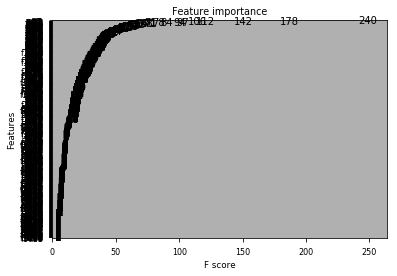

In [26]:
%%time
# Adjust the class labels so it starts with 0
y_adj = y-1

scores = []

iteration = 1
for i in range(iteration):
    print('========== Iteration %d/%d ==========' % (i+1, iteration))
    
    # Split into test and train randomly, every iteration
    x1, x2, y1, y2 = train_test_split(selectX2, y_adj, test_size=0.15)
    
    # Set up parameters for xgboost
    params = {
            'eta': 0.1,
            'gamma': 0.8,
            'max_delta_step': 1,
            'max_depth': 12,
            'min_child_weight': 1,
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'num_class': 9,
            'seed': 1,
            'silent': True,
            'nthread' :4
            }

    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

    model3 = xgb.train(params, xgb.DMatrix(x1, y1), 500,  watchlist, 
                      verbose_eval=100, early_stopping_rounds=100)

    score = log_loss(y2, model3.predict(xgb.DMatrix(x2), 
                     ntree_limit=model3.best_ntree_limit), 
                     labels = list(range(9)))
    scores.append(score)
          
print("Average mlogloss: %f" % np.mean(scores))
plot_importance(model3)

<b>Take features with 50 percentile Gain Score, retry classification</b>

In [41]:
gain_scores = pd.DataFrame([val for val in model.get_score(importance_type='gain').values()])
gain_scores.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9])

,0
count,1186.000000
mean,2.659606
std,2.750952
min,0.516536
25%,1.400534
50%,2.007592
75%,2.960491
80%,3.334636
90%,4.836315
max,49.999929


In [42]:
select_feat_ind3 = [int(key.replace('f', '')) for key, value in model.get_score(importance_type='gain').items() if value >=2.007592]

selectX3 = X[:, select_feat_ind3]
print('Before selection', X.shape)
print('After selection', selectX3.shape)

Before selection (3321, 24504)
After selection (3321, 593)


In [43]:
features.iloc[:, select_feat_ind3].to_csv('./data/feature_matrix_TfIdf_gainscore1.csv', index=False)

========== Iteration 1/1 ==========
[0]	train-mlogloss:2.08427	valid-mlogloss:2.1103
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[213]	train-mlogloss:0.299021	valid-mlogloss:0.958116

Average mlogloss: 0.958116
CPU times: user 5min 44s, sys: 68.4 ms, total: 5min 44s
Wall time: 1min 27s


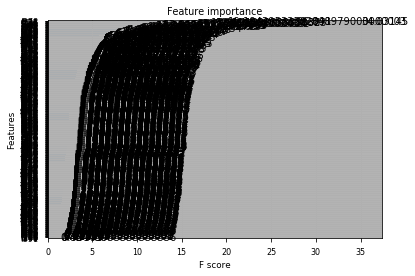

In [44]:
%%time
# Adjust the class labels so it starts with 0
y_adj = y-1

scores = []

iteration = 1
for i in range(iteration):
    print('========== Iteration %d/%d ==========' % (i+1, iteration))
    
    # Split into test and train randomly, every iteration
    x1, x2, y1, y2 = train_test_split(selectX3, y_adj, test_size=0.15)
    
    # Set up parameters for xgboost
    params = {
            'eta': 0.1,
            'gamma': 0.8,
            'max_delta_step': 1,
            'max_depth': 12,
            'min_child_weight': 1,
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'num_class': 9,
            'seed': 1,
            'silent': True,
            'nthread' :4
            }

    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

    model4 = xgb.train(params, xgb.DMatrix(x1, y1), 500,  watchlist, 
                      verbose_eval=500, early_stopping_rounds=100)

    score = log_loss(y2, model4.predict(xgb.DMatrix(x2), 
                     ntree_limit=model4.best_ntree_limit), 
                     labels = list(range(9)))
    scores.append(score)
          
print("Average mlogloss: %f" % np.mean(scores))
plot_importance(model4, importance_type='gain')

<b>PCA to visualize vector space</b>

Whole X

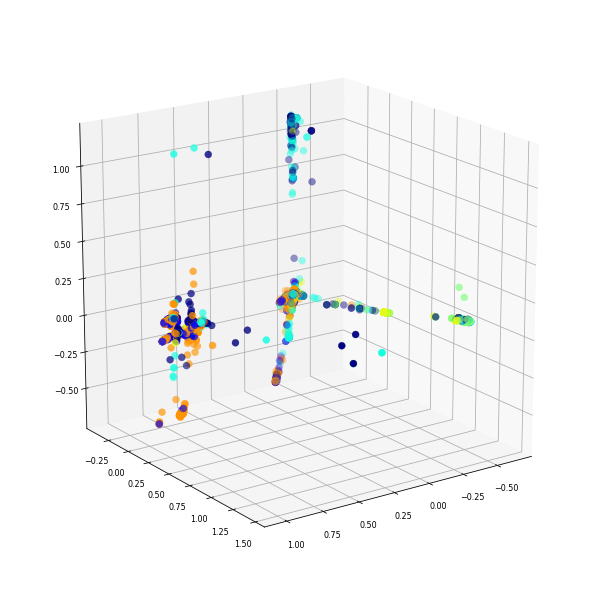

In [27]:
# Create a new table with ID as index
pca_table = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X)
pca_table['x'] = pca.fit_transform(X).T[0]
pca_table['y'] = pca.fit_transform(X).T[1]
pca_table['z'] = pca.fit_transform(X).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table.x, pca_table.y, pca_table.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

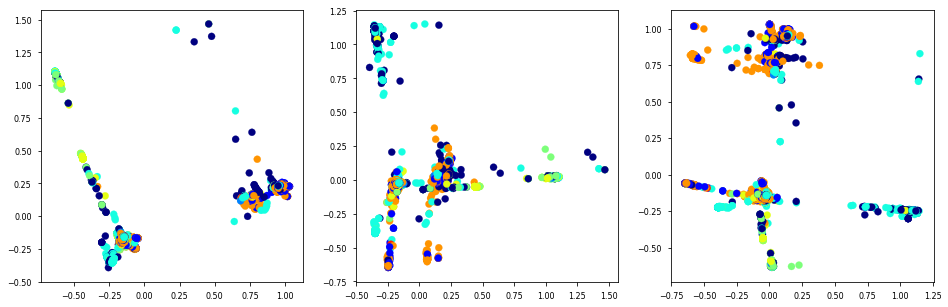

In [29]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table.x, pca_table.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table.y, pca_table.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table.z, pca_table.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

selectX1

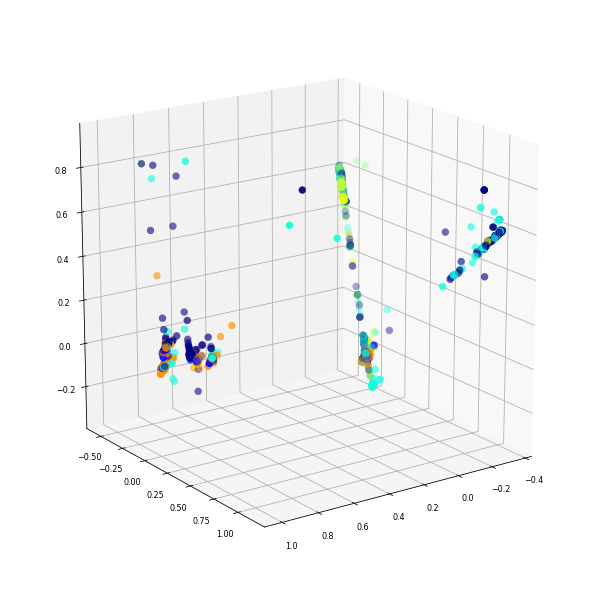

In [30]:
# Create a new table with ID as index
pca_table1 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(selectX1)
pca_table1['x'] = pca.fit_transform(selectX1).T[0]
pca_table1['y'] = pca.fit_transform(selectX1).T[1]
pca_table1['z'] = pca.fit_transform(selectX1).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table1.x, pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

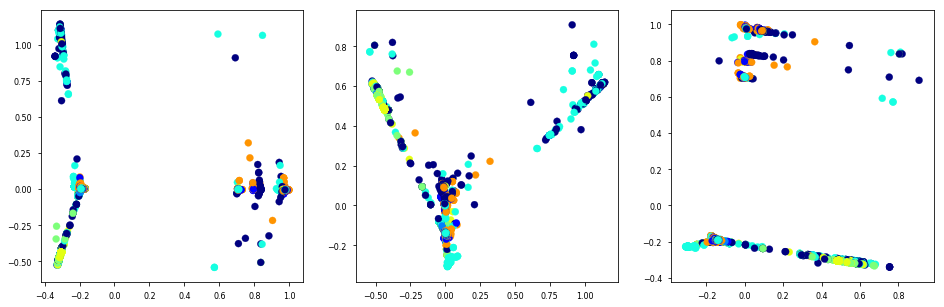

In [31]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table1.x, pca_table1.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table1.z, pca_table1.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

selectX2

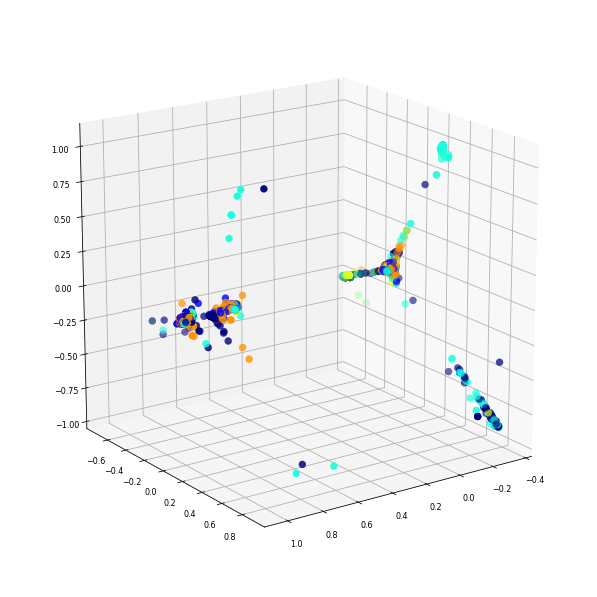

In [32]:
# Create a new table with ID as index
pca_table2 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(selectX2)
pca_table2['x'] = pca.fit_transform(selectX2).T[0]
pca_table2['y'] = pca.fit_transform(selectX2).T[1]
pca_table2['z'] = pca.fit_transform(selectX2).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table2.x, pca_table2.y, pca_table2.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

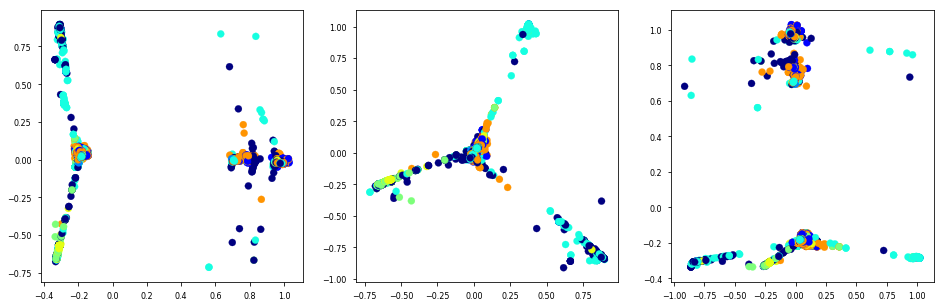

In [33]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table2.x, pca_table2.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table2.y, pca_table2.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table2.z, pca_table2.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

selectX3

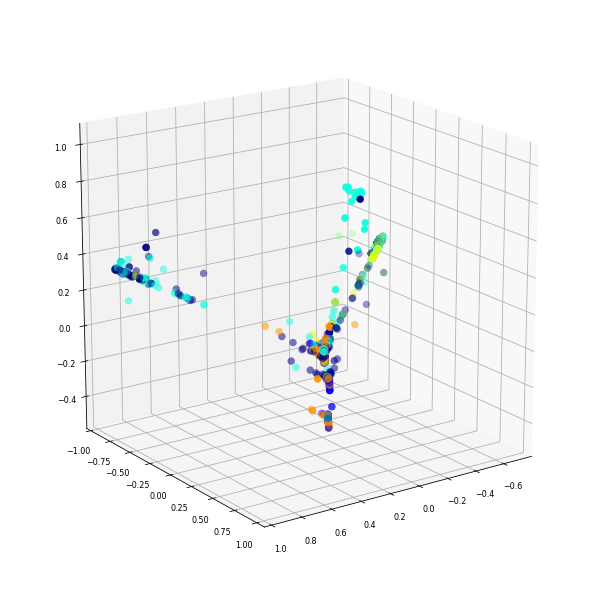

In [45]:
# Create a new table with ID as index
pca_table3 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(selectX3)
pca_table3['x'] = pca.fit_transform(selectX3).T[0]
pca_table3['y'] = pca.fit_transform(selectX3).T[1]
pca_table3['z'] = pca.fit_transform(selectX3).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table3.x, pca_table3.y, pca_table3.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

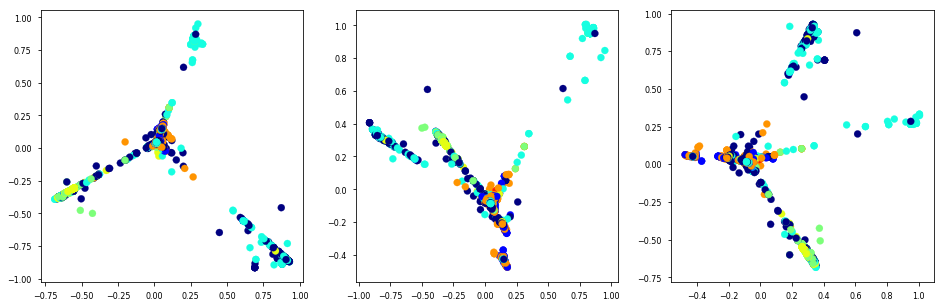

In [46]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table3.x, pca_table3.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table3.y, pca_table3.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table3.z, pca_table3.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')